In [2]:
#accessing netcdf files from Hector's folders
import os, glob, sys
sys.path.append("//nobackup//amondal//Python//Hector_Python_Scripts")
sys.path.append("//nobackup/amondal//Python//mit_geos_analysis")
#from mds_store import openmdsdataset
#playing with netcdf - xarray
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
# How about visualization?
%matplotlib inline
import netCDF4
from netCDF4 import Dataset
#from xmitgcm import open_mdsdataset
from GetNCDataSet import getMITNCDataSet
from MITllc2160Depth import *
sys.path.append("//nobackup/amondal//Python//xmitgcm//xmitgcm")
from xmitgcm.mds_store import open_mdsdataset
import xrft

from dask.distributed import Client
client = Client(memory_limit='90GB',n_workers = 40, threads_per_worker=1)

/home6/amondal/.conda/envs/xmitgcm3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36237 instead
  warnings.warn(


In [3]:
from spectral_analysis_code import *

First I'll look at this smaller section where the issues seems to be quite severe

In [4]:
W = getMITNCDataSet('/nobackup/amondal/NCData/20211116_QTprime_openocean_3month/', 'W', 15,15)

FileNotFoundError: [Errno 2] No such file or directory: '/nobackup/amondal/NCData/20211116_QTprime_openocean_3month/W_15/'

In [4]:
Wc = W.compute()
Wc

<xarray.Dataset>
Dimensions:  (lat: 300, lon: 375, time: 2208)
Coordinates:
  * lat      (lat) float64 30.0 30.04 30.08 30.12 ... 41.84 41.88 41.92 41.96
  * lon      (lon) float64 -60.0 -59.96 -59.92 -59.88 ... -45.12 -45.08 -45.04
Dimensions without coordinates: time
Data variables:
    W        (time, lat, lon) float64 -0.0001791 -0.0001791 ... 5.382e-05

In [5]:
W15_reg = regularizeCoordinates(Wc.W, 'linear', timeunits = 'hours')

In [6]:
W15_reg_w = W15_reg[0:1250]

In [7]:
W15_reg2_w = xrft.detrend(W15_reg_w, dim = 'time', detrend_type = 'linear')
W15_reg3_w = xrft.detrend(W15_reg2_w, dim = ['xdim','ydim'], detrend_type = 'linear')

In [171]:
W15_spectra_dk = xrft.power_spectrum(W15_reg3_w, dim=['xdim','ydim', 'time'], real_dim="time", true_amplitude=True, window="hann", window_correction=True).sortby(["freq_xdim","freq_ydim"], spacing_tol = True)

TypeError: sortby() got an unexpected keyword argument 'spacing_tol'

In [9]:
W15_spectra_spacing = W15_spectra_dk["freq_xdim"].spacing * W15_spectra_dk["freq_ydim"].spacing * W15_spectra_dk["freq_time"].spacing

In [10]:
W15_spectra_spacing

7.188632998043695e-10

In [14]:
W15_spectra = W15_spectra_dk # W15_spectra_spacing

In [15]:
W15_spectra_iso = isotropize(W15_spectra, ['freq_xdim', 'freq_ydim'], 'freq_time')

In [23]:
W15_spectra_iso

<xarray.DataArray (freq_time: 626, freq_r: 70)>
array([[1.21836522e+02, 1.53468535e+02, 2.71575510e+02, ...,
        1.85248167e+03, 1.89599176e+03, 1.78328735e+03],
       [3.78906675e+02, 5.66319181e+02, 7.23495787e+02, ...,
        9.52547027e+03, 9.33779633e+03, 9.88225264e+03],
       [4.23895449e+02, 5.81107213e+02, 7.68535402e+02, ...,
        1.51441033e+04, 1.54914359e+04, 1.49665326e+04],
       ...,
       [1.65970735e+00, 4.74826752e-01, 3.16409414e-01, ...,
        5.88824531e+00, 7.82608423e+00, 6.06771809e+00],
       [2.02526249e+00, 4.77662530e-01, 3.40004523e-01, ...,
        7.01183421e+00, 7.84133846e+00, 7.48240674e+00],
       [7.80734721e-01, 2.16117043e-01, 1.79739227e-01, ...,
        3.76145733e+00, 4.03871871e+00, 4.49340756e+00]])
Coordinates:
  * freq_time  (freq_time) float64 0.0 0.0008 0.0016 ... 0.4984 0.4992 0.5
  * freq_r     (freq_r) float64 0.0008071 0.002421 0.004036 ... 0.1106 0.1122

In [16]:
Eisop15_w = W15_spectra_iso[1:].values
omp15_w = W15_spectra_iso.freq_time[1:].values
#kisop15_w = Qp15_w_iso.freq_r.values
kisop15_w = W15_spectra_iso.freq_r.values


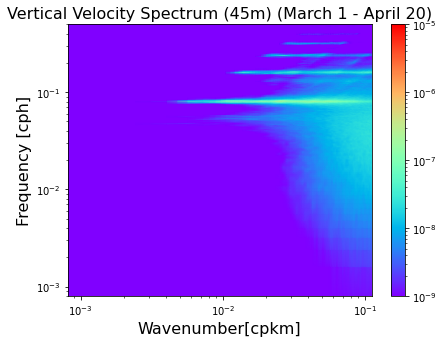

In [25]:
%matplotlib inline
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(122)
cs = plt.pcolormesh(kisop15_w, omp15_w, (Eisop15_w*kisop15_w[None,...]*omp15_w[...,None]), shading='gouraud', cmap='rainbow', norm=LogNorm())
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title(r'Vertical Velocity Spectrum (45m) (March 1 - April 20)', size = 16)
plt.xlabel(r'Wavenumber[cpkm]', size=16)
plt.ylabel(r'Frequency [cph]', size = 16)
plt.clim([1e-5,1e-9])
plt.colorbar()
plt.show()

In [29]:
W15_spectra_iso_kplot = W15_spectra_iso.sum('freq_time')
W15_spectra_iso_kplot

<xarray.DataArray (freq_r: 70)>
array([  23604.98321648,   80591.90681376,  130760.74746602,
        558993.347865  ,  463943.32880946,  589880.74728219,
        985762.71348453, 1037388.94336713, 1074549.74731098,
        906721.52645611,  858339.20934971,  987477.5478708 ,
       1006997.95221365,  959623.92099697, 1187964.19879705,
       1425119.81123506, 1333086.46680042, 1218616.31087107,
       1185960.51463489, 1185541.7215767 , 1188924.00744128,
       1196053.86082857, 1242501.59218048, 1294048.10714106,
       1296785.32739915, 1317125.36704867, 1356607.64207307,
       1365980.13738152, 1335897.63045454, 1356106.63608455,
       1322905.46410475, 1310090.31670414, 1336633.569515  ,
       1339522.71752369, 1356394.19423387, 1351464.30380898,
       1324566.90040941, 1331651.13674923, 1335808.3546285 ,
       1313742.09274213, 1269599.33681468, 1274317.96699201,
       1252106.12632509, 1260100.90398892, 1232426.49455546,
       1240515.41048018, 1211926.22081023, 1195411.57299242,
       1204688.55463759, 1180199.42148153, 1176805.41069767,
       1177435.30765667, 1173986.82944518, 1144795.1064996 ,
       1144831.93118676, 1112399.51992149, 1114821.59721979,
       1081946.09455272, 1064273.71909931, 1063566.4683046 ,
       1039240.91192496, 1030094.0340929 , 1020853.78921688,
       1015448.23702956, 1015430.26762483, 1001793.54406409,
       1005521.57417793,  956223.42127526,  963757.07742662,
        941568.4072382 ])
Coordinates:
  * freq_r   (freq_r) float64 0.0008071 0.002421 0.004036 ... 0.1106 0.1122

Text(0.5, 1.0, 'Vertical Velocity Spectrum (45m) (March 1 - April 20)')

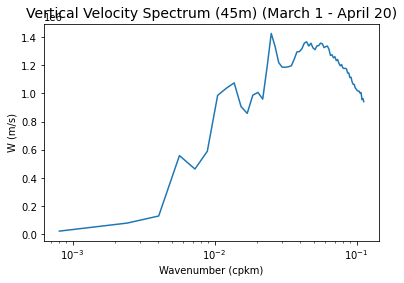

In [35]:
%matplotlib inline
W15_spectra_iso_kplot.plot(xscale = 'log')

plt.ylabel('W (m/s)')
plt.xlabel('Wavenumber (cpkm)')
plt.title(r'Vertical Velocity Spectrum (45m) (March 1 - April 20)', size = 14)

----------------------------------------------------------------------------------------------------------------

Trying to just use Hector's code - I suspect spec_est3 will give me everything I need. Converting between xarray and numpy and doing so efficiently is the challenge.

In [27]:
W15_reg3_w
#so time is the first dimension, then xdim, then ydim

<xarray.DataArray (time: 1250, xdim: 300, ydim: 375)>
array([[[-2.30974439e-04, -2.30892618e-04, -7.97816295e-05, ...,
          6.48987912e-04, -3.64325326e-05,  1.03278322e-04],
        [-2.35088379e-04, -2.35006559e-04, -6.84247836e-05, ...,
          3.43674030e-04, -4.87765533e-04, -4.04332962e-05],
        [-3.85964175e-05, -3.85145968e-05,  1.12492375e-04, ...,
          1.14937841e-04, -6.82840248e-04, -1.60081511e-04],
        ...,
        [-1.57107518e-04, -1.57025697e-04,  1.45427467e-04, ...,
          3.48515731e-04, -1.14853580e-05, -3.67450542e-04],
        [-5.00237674e-05, -4.99419467e-05,  1.20546075e-05, ...,
         -1.01086183e-04, -1.18780821e-04, -1.69934280e-04],
        [-4.48288421e-05, -4.47470214e-05, -1.43719972e-04, ...,
          2.95075134e-05, -2.76836601e-04, -2.70507255e-04]],

       [[ 1.83430138e-06,  1.88094928e-06,  1.63261763e-04, ...,
          6.97449192e-04,  7.77887328e-05,  2.00927746e-04],
        [-1.22561512e-04, -1.22514864e-04,  2.84545562e-05, ...,
          4.58281344e-05, -8.11019793e-04, -1.45201735e-04],
        [-7.61943780e-05, -7.61477301e-05,  5.99678131e-05, ...,
         -1.92575663e-04, -1.09474745e-03, -3.62262166e-04],
...
        [-4.29647205e-05, -4.29654917e-05,  2.56616393e-05, ...,
         -4.47921104e-04, -3.48178884e-04, -3.34973422e-05],
        [-1.01318271e-04, -1.01319042e-04, -2.88172865e-05, ...,
         -3.72367287e-05, -5.36819894e-05,  9.92678980e-06],
        [-5.44796233e-04, -5.44797004e-04, -4.85910065e-04, ...,
         -2.86234007e-04,  6.39251233e-05, -3.65464844e-05]],

       [[-3.39824262e-04, -3.39850578e-04,  3.86345783e-05, ...,
          1.48556704e-04,  4.43817526e-04,  1.28658507e-04],
        [-5.38036678e-04, -5.38062994e-04,  8.71255331e-05, ...,
          4.69605475e-04,  3.96629876e-04, -3.75528720e-04],
        [-4.97558715e-04, -4.97585030e-04,  3.61972901e-05, ...,
          3.92090836e-04, -3.78451791e-05, -3.08895670e-04],
        ...,
        [ 3.41573559e-04,  3.41547243e-04,  4.85138159e-04, ...,
         -3.52166167e-04, -2.47413649e-04, -5.83778127e-05],
        [ 2.63121702e-04,  2.63095387e-04,  3.80471456e-04, ...,
          1.14395800e-04,  4.10551249e-05, -9.95251121e-05],
        [-2.36688653e-04, -2.36714969e-04, -1.06885126e-04, ...,
         -2.27072793e-04,  6.15753781e-05, -9.51780447e-05]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 1.247e+03 1.248e+03 1.249e+03
  * xdim     (xdim) float64 0.0 2.224 4.448 6.672 ... 658.3 660.5 662.7 665.0
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 1.655e+03 1.659e+03 1.664e+03

In [31]:
W15_reg3_w_np = W15_reg3_w.values
W15_reg3_w_np_swap = np.swapaxes(np.swapaxes(W15_reg3_w, 0, 1), 1,2)

In [32]:
W15_reg3_w_np_swap.shape

(300, 375, 1250)

In [37]:
dx = W15_reg3_w.xdim.diff('xdim').mean().values
dy = W15_reg3_w.ydim.diff('ydim').mean().values
dt = W15_reg3_w.time.diff('time').mean().values

In [77]:
dt

array(1.)

In [35]:
import wf_spectrum

In [78]:
Eu,k,l,om = wf_spectrum.spec_est3(W15_reg3_w_np_swap,dx,dy,dt)

In [79]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei

In [80]:
Eiso_units= Eiso#*4.2e6
Eiso_units.shape

(70, 626)

In [83]:
Eiso_filter = np.where(Eiso < 1e-10, 0, Eiso)

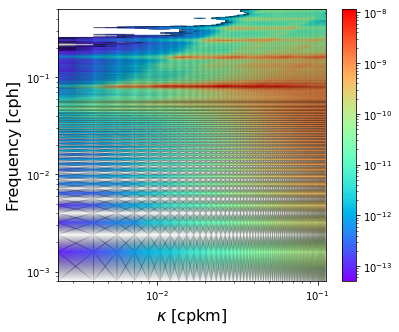

In [84]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(6,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,1*Eiso_filter.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='rainbow',norm=LogNorm() )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.xlabel(r'$\kappa$ [cpkm]',size=16)
plt.ylabel(r'Frequency [cph]',size=16)
#plt.clim([0.1,-0.1])
plt.colorbar()
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')

plt.show()


In [56]:
Eiso.shape

(70, 626)

In [57]:
kk.shape

(69,)

In [58]:
omm.shape

(625,)

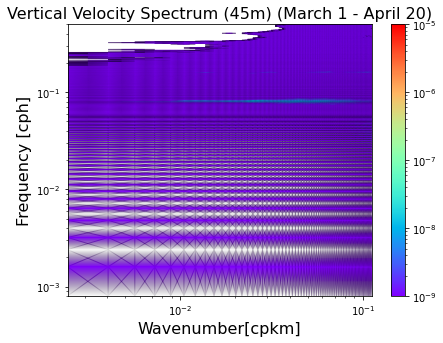

In [85]:
%matplotlib inline
from matplotlib.colors import LogNorm
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(122)
cs=plt.pcolormesh(kk,omm,1*Eiso_filter.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='rainbow',norm=LogNorm() )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title(r'Vertical Velocity Spectrum (45m) (March 1 - April 20)', size = 16)
plt.xlabel(r'Wavenumber[cpkm]', size=16)
plt.ylabel(r'Frequency [cph]', size = 16)
plt.clim([1e-5,1e-9])
plt.colorbar()
plt.show()

In [1]:
W15 = xr.load_dataset('/nobackup/amondal/NCData/W15_reg_for_Hector.nc4')

NameError: name 'xr' is not defined

In [207]:
W15 = W15['__xarray_dataarray_variable__']

In [89]:
W15

<xarray.DataArray '__xarray_dataarray_variable__' (time: 2208, xdim: 300, ydim: 375)>
array([[[-1.79072056e-04, -1.79072056e-04,  1.40419088e-05, ...,
          6.94546849e-04, -5.72377467e-05,  1.71237916e-04],
        [-1.90685940e-04, -1.90685940e-04,  3.65297383e-05, ...,
          3.92997375e-04, -4.30897664e-04, -2.05140750e-05],
        [ 2.97633414e-05,  2.97633414e-05,  1.76064001e-04, ...,
          1.32667337e-04, -6.93743466e-04, -2.09442544e-04],
        ...,
        [-8.97452555e-05, -8.97452555e-05,  2.82943627e-04, ...,
          6.29509814e-05, -5.04362069e-05, -2.01856703e-04],
        [ 2.58425571e-05,  2.58425571e-05,  1.38801173e-04, ...,
         -2.74639227e-04, -2.47196149e-04, -2.91474396e-04],
        [ 3.76986418e-06,  3.76986418e-06, -2.98216310e-05, ...,
         -1.52595079e-04, -6.50198053e-05, -5.23657873e-05]],

       [[ 4.18512936e-05,  4.18512936e-05,  2.45252886e-04, ...,
          7.44183664e-04,  5.82686989e-05,  2.70126970e-04],
        [-9.00370796e-05, -9.00370796e-05,  1.21546596e-04, ...,
          9.62953054e-05, -7.52933905e-04, -1.23979684e-04],
        [-1.97881527e-05, -1.97881527e-05,  1.11717061e-04, ...,
         -1.73661450e-04, -1.10437348e-03, -4.10272798e-04],
...
        [ 5.95370482e-04,  5.95370482e-04, -2.74199876e-04, ...,
         -6.54706237e-05,  1.26383704e-04,  3.47939553e-04],
        [ 5.00473485e-04,  5.00473485e-04, -4.01498808e-04, ...,
         -1.49221451e-04, -1.47778046e-04, -5.04979562e-06],
        [ 3.30017385e-04,  3.30017385e-04, -4.68386686e-04, ...,
          7.59719987e-05, -1.45967442e-06, -5.16377077e-05]],

       [[ 2.92079465e-04,  2.92079465e-04,  4.65510064e-04, ...,
          1.02395122e-03, -1.95911503e-04, -6.83746533e-04],
        [ 3.06014204e-04,  3.06014204e-04,  5.19809430e-04, ...,
          6.38214755e-04, -3.69670888e-04, -4.67681733e-04],
        [-9.05534107e-05, -9.05534107e-05,  3.99219483e-04, ...,
          6.80924422e-05, -3.12382297e-04, -9.97251336e-05],
        ...,
        [ 2.49944918e-04,  2.49944918e-04, -8.95821358e-05, ...,
          2.60957186e-05, -1.92118023e-05,  6.48331770e-05],
        [ 3.89522756e-04,  3.89522756e-04, -1.39907686e-04, ...,
          3.02137109e-04,  5.16373366e-05, -7.44520294e-05],
        [ 5.06728771e-04,  5.06728771e-04, -1.79205555e-04, ...,
          3.41602397e-04,  3.26617737e-04,  5.38164095e-05]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 2.205e+03 2.206e+03 2.207e+03
  * xdim     (xdim) float64 0.0 2.224 4.448 6.672 ... 658.3 660.5 662.7 665.0
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 1.655e+03 1.659e+03 1.664e+03

In [208]:
W15_np = W15.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)

In [113]:
W15_np_swap.shape

(300, 375, 2208)

In [209]:
dx = W15.xdim.diff('xdim').mean().values
dy = W15.ydim.diff('ydim').mean().values
dt = W15.time.diff('time').mean().values

In [116]:
dt

array(1.)

In [210]:
# detrend: space and time
from scipy import signal
u = W15_np_swap
u = signal.detrend(u,axis=0,type='linear')
u = signal.detrend(u,axis=1,type='linear')
u = signal.detrend(u,axis=2,type='linear')
print('------- End detrending --------')

------- End detrending --------


In [107]:
2208/30

73.6

In [211]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om = wf_spectrum.spec_est3(uaux,dy,dy,dt)
      else:
         Eua,_,_,_ = wf_spectrum.spec_est3(uaux,dy,dy,1)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1


In [212]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [213]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [150]:
np.isnan(Eiso).sum()

0

In [80]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

(70, 626)

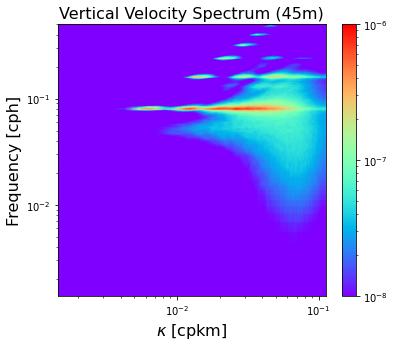

In [215]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(6,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='rainbow',norm=LogNorm() )

ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Velocity Spectrum (45m)', size=16)
plt.xlabel(r'$\kappa$ [cpkm]',size=16)
plt.ylabel(r'Frequency [cph]',size=16)
plt.clim([1e-8,1e-6])
plt.colorbar()
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')

plt.show()


In [ ]:
#dx being different than dy means you resolve higher scales in one dimension than the other. it gives you aliasing
# use the same dimension

In [152]:
W15 = xr.load_dataset('/nobackup/amondal/NCData/W15_reg_for_Hector.nc4')
T15 = xr.load_dataset('/nobackup/amondal/NCData/Theta15_reg_for_Hector.nc4')

In [153]:
T15

<xarray.Dataset>
Dimensions:                        (time: 2208, xdim: 300, ydim: 375)
Coordinates:
  * time                           (time) float64 0.0 1.0 ... 2.207e+03
  * xdim                           (xdim) float64 0.0 2.224 ... 662.7 665.0
  * ydim                           (ydim) float64 0.0 4.448 ... 1.664e+03
Data variables:
    __xarray_dataarray_variable__  (time, xdim, ydim) float64 20.03 ... 15.26

In [154]:
W15 = W15['__xarray_dataarray_variable__']
T15 = T15['__xarray_dataarray_variable__']

In [89]:
W15

<xarray.DataArray '__xarray_dataarray_variable__' (time: 2208, xdim: 300, ydim: 375)>
array([[[-1.79072056e-04, -1.79072056e-04,  1.40419088e-05, ...,
          6.94546849e-04, -5.72377467e-05,  1.71237916e-04],
        [-1.90685940e-04, -1.90685940e-04,  3.65297383e-05, ...,
          3.92997375e-04, -4.30897664e-04, -2.05140750e-05],
        [ 2.97633414e-05,  2.97633414e-05,  1.76064001e-04, ...,
          1.32667337e-04, -6.93743466e-04, -2.09442544e-04],
        ...,
        [-8.97452555e-05, -8.97452555e-05,  2.82943627e-04, ...,
          6.29509814e-05, -5.04362069e-05, -2.01856703e-04],
        [ 2.58425571e-05,  2.58425571e-05,  1.38801173e-04, ...,
         -2.74639227e-04, -2.47196149e-04, -2.91474396e-04],
        [ 3.76986418e-06,  3.76986418e-06, -2.98216310e-05, ...,
         -1.52595079e-04, -6.50198053e-05, -5.23657873e-05]],

       [[ 4.18512936e-05,  4.18512936e-05,  2.45252886e-04, ...,
          7.44183664e-04,  5.82686989e-05,  2.70126970e-04],
        [-9.00370796e-05, -9.00370796e-05,  1.21546596e-04, ...,
          9.62953054e-05, -7.52933905e-04, -1.23979684e-04],
        [-1.97881527e-05, -1.97881527e-05,  1.11717061e-04, ...,
         -1.73661450e-04, -1.10437348e-03, -4.10272798e-04],
...
        [ 5.95370482e-04,  5.95370482e-04, -2.74199876e-04, ...,
         -6.54706237e-05,  1.26383704e-04,  3.47939553e-04],
        [ 5.00473485e-04,  5.00473485e-04, -4.01498808e-04, ...,
         -1.49221451e-04, -1.47778046e-04, -5.04979562e-06],
        [ 3.30017385e-04,  3.30017385e-04, -4.68386686e-04, ...,
          7.59719987e-05, -1.45967442e-06, -5.16377077e-05]],

       [[ 2.92079465e-04,  2.92079465e-04,  4.65510064e-04, ...,
          1.02395122e-03, -1.95911503e-04, -6.83746533e-04],
        [ 3.06014204e-04,  3.06014204e-04,  5.19809430e-04, ...,
          6.38214755e-04, -3.69670888e-04, -4.67681733e-04],
        [-9.05534107e-05, -9.05534107e-05,  3.99219483e-04, ...,
          6.80924422e-05, -3.12382297e-04, -9.97251336e-05],
        ...,
        [ 2.49944918e-04,  2.49944918e-04, -8.95821358e-05, ...,
          2.60957186e-05, -1.92118023e-05,  6.48331770e-05],
        [ 3.89522756e-04,  3.89522756e-04, -1.39907686e-04, ...,
          3.02137109e-04,  5.16373366e-05, -7.44520294e-05],
        [ 5.06728771e-04,  5.06728771e-04, -1.79205555e-04, ...,
          3.41602397e-04,  3.26617737e-04,  5.38164095e-05]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 2.205e+03 2.206e+03 2.207e+03
  * xdim     (xdim) float64 0.0 2.224 4.448 6.672 ... 658.3 660.5 662.7 665.0
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 1.655e+03 1.659e+03 1.664e+03

In [155]:
W15_np = W15.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [156]:
T15_np_swap.shape

(300, 375, 2208)

In [92]:
dx = W15.xdim.diff('xdim').mean().values
dy = W15.ydim.diff('ydim').mean().values
dt = W15.time.diff('time').mean().values

In [116]:
dt

array(1.)

In [157]:
# detrend: space and time
from scipy import signal
u = W15_np_swap
v = T15_np_swap
u = signal.detrend(u,axis=0,type='linear')
u = signal.detrend(u,axis=1,type='linear')
u = signal.detrend(u,axis=2,type='linear')
v = signal.detrend(v,axis=0,type='linear')
v = signal.detrend(v,axis=1,type='linear')
v = signal.detrend(v,axis=2,type='linear')
print('------- End detrending --------')

------- End detrending --------


In [107]:
2208/30

73.6

In [158]:
import co_spec

In [159]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
300 375 720
0.11241116021940924
0.11241116021940924
before fftn
300 375 720
0.11241116021940924
0.11241116021940924
before fftn
300 375 720
0.11241116021940924
0.11241116021940924


In [160]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [161]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [166]:
Eiso_units = Eiso*4.2e6# rho Cp

In [162]:
np.isnan(Eiso).sum()

0

In [80]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

(70, 626)

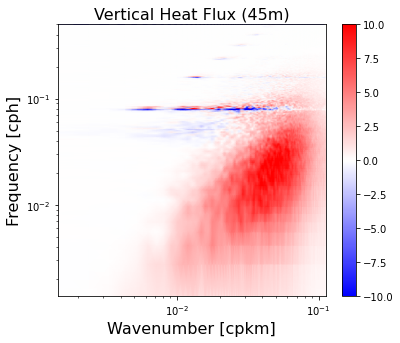

In [182]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(6,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Vertical Heat Flux (45m)', size=16)
plt.xlabel(r'Wavenumber [cpkm]',size=16)
plt.ylabel(r'Frequency [cph]',size=16)
plt.clim([-10,10])
plt.colorbar()
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')

plt.show()


In [ ]:
#dx being different than dy means you resolve higher scales in one dimension than the other. it gives you aliasing
# use the same dimension

In [152]:
W15 = xr.load_dataset('/nobackup/amondal/NCData/W15_reg_for_Hector.nc4')
T15 = xr.load_dataset('/nobackup/amondal/NCData/Theta15_reg_for_Hector.nc4')

In [153]:
T15

<xarray.Dataset>
Dimensions:                        (time: 2208, xdim: 300, ydim: 375)
Coordinates:
  * time                           (time) float64 0.0 1.0 ... 2.207e+03
  * xdim                           (xdim) float64 0.0 2.224 ... 662.7 665.0
  * ydim                           (ydim) float64 0.0 4.448 ... 1.664e+03
Data variables:
    __xarray_dataarray_variable__  (time, xdim, ydim) float64 20.03 ... 15.26

In [154]:
W15 = W15['__xarray_dataarray_variable__']
T15 = T15['__xarray_dataarray_variable__']

In [89]:
W15

<xarray.DataArray '__xarray_dataarray_variable__' (time: 2208, xdim: 300, ydim: 375)>
array([[[-1.79072056e-04, -1.79072056e-04,  1.40419088e-05, ...,
          6.94546849e-04, -5.72377467e-05,  1.71237916e-04],
        [-1.90685940e-04, -1.90685940e-04,  3.65297383e-05, ...,
          3.92997375e-04, -4.30897664e-04, -2.05140750e-05],
        [ 2.97633414e-05,  2.97633414e-05,  1.76064001e-04, ...,
          1.32667337e-04, -6.93743466e-04, -2.09442544e-04],
        ...,
        [-8.97452555e-05, -8.97452555e-05,  2.82943627e-04, ...,
          6.29509814e-05, -5.04362069e-05, -2.01856703e-04],
        [ 2.58425571e-05,  2.58425571e-05,  1.38801173e-04, ...,
         -2.74639227e-04, -2.47196149e-04, -2.91474396e-04],
        [ 3.76986418e-06,  3.76986418e-06, -2.98216310e-05, ...,
         -1.52595079e-04, -6.50198053e-05, -5.23657873e-05]],

       [[ 4.18512936e-05,  4.18512936e-05,  2.45252886e-04, ...,
          7.44183664e-04,  5.82686989e-05,  2.70126970e-04],
        [-9.00370796e-05, -9.00370796e-05,  1.21546596e-04, ...,
          9.62953054e-05, -7.52933905e-04, -1.23979684e-04],
        [-1.97881527e-05, -1.97881527e-05,  1.11717061e-04, ...,
         -1.73661450e-04, -1.10437348e-03, -4.10272798e-04],
...
        [ 5.95370482e-04,  5.95370482e-04, -2.74199876e-04, ...,
         -6.54706237e-05,  1.26383704e-04,  3.47939553e-04],
        [ 5.00473485e-04,  5.00473485e-04, -4.01498808e-04, ...,
         -1.49221451e-04, -1.47778046e-04, -5.04979562e-06],
        [ 3.30017385e-04,  3.30017385e-04, -4.68386686e-04, ...,
          7.59719987e-05, -1.45967442e-06, -5.16377077e-05]],

       [[ 2.92079465e-04,  2.92079465e-04,  4.65510064e-04, ...,
          1.02395122e-03, -1.95911503e-04, -6.83746533e-04],
        [ 3.06014204e-04,  3.06014204e-04,  5.19809430e-04, ...,
          6.38214755e-04, -3.69670888e-04, -4.67681733e-04],
        [-9.05534107e-05, -9.05534107e-05,  3.99219483e-04, ...,
          6.80924422e-05, -3.12382297e-04, -9.97251336e-05],
        ...,
        [ 2.49944918e-04,  2.49944918e-04, -8.95821358e-05, ...,
          2.60957186e-05, -1.92118023e-05,  6.48331770e-05],
        [ 3.89522756e-04,  3.89522756e-04, -1.39907686e-04, ...,
          3.02137109e-04,  5.16373366e-05, -7.44520294e-05],
        [ 5.06728771e-04,  5.06728771e-04, -1.79205555e-04, ...,
          3.41602397e-04,  3.26617737e-04,  5.38164095e-05]]])
Coordinates:
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 2.205e+03 2.206e+03 2.207e+03
  * xdim     (xdim) float64 0.0 2.224 4.448 6.672 ... 658.3 660.5 662.7 665.0
  * ydim     (ydim) float64 0.0 4.448 8.896 ... 1.655e+03 1.659e+03 1.664e+03

In [172]:
W15_t = xrft.detrend(W15, dim = 'time', detrend_type = 'linear')
W15_txy = xrft.detrend(W15_t, dim = ['xdim','ydim'], detrend_type = 'linear')
T15_t = xrft.detrend(T15, dim = 'time', detrend_type = 'linear')
T15_txy = xrft.detrend(T15_t, dim = ['xdim','ydim'], detrend_type = 'linear')

In [173]:
W15_np = W15_txy.values
W15_np_swap = np.swapaxes(np.swapaxes(W15_np, 0, 1), 1,2)
T15_np = T15_txy.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1, 2)

In [174]:
dx = W15.xdim.diff('xdim').mean().values
dy = W15.ydim.diff('ydim').mean().values
dt = W15.time.diff('time').mean().values

In [116]:
dt

array(1.)

In [175]:
u = W15_np_swap
v = T15_np_swap

In [176]:
import co_spec

In [177]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      vaux = v[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om, df1, df2, df3 = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
      else:
         Eua,_,_,_,_,_,_ = co_spec.spec_est3(uaux, vaux,dy,dy,dt)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1
before fftn
300 375 720
0.11241116021940924
0.11241116021940924
before fftn
300 375 720
0.11241116021940924
0.11241116021940924
before fftn
300 375 720
0.11241116021940924
0.11241116021940924


In [178]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [179]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [180]:
Eiso_units = Eiso*4.2e6# rho Cp

In [162]:
np.isnan(Eiso).sum()

0

In [80]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

(70, 626)

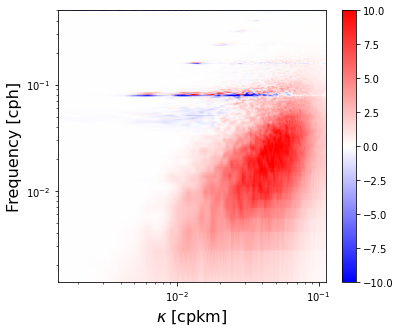

In [181]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(6,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso_units.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='bwr' )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.xlabel(r'$\kappa$ [cpkm]',size=16)
plt.ylabel(r'Frequency [cph]',size=16)
plt.clim([-10,10])
plt.colorbar()
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')

plt.show()


In [218]:
T15 = xr.load_dataset('/nobackup/amondal/NCData/Theta15_reg_for_Hector.nc4')

In [219]:
T15 = T15['__xarray_dataarray_variable__']

In [220]:
T15_np = T15.values
T15_np_swap = np.swapaxes(np.swapaxes(T15_np, 0, 1), 1,2)

In [221]:
T15_np_swap.shape

(300, 375, 2208)

In [222]:
dx = T15.xdim.diff('xdim').mean().values
dy = T15.ydim.diff('ydim').mean().values
dt = T15.time.diff('time').mean().values

In [223]:
dt

array(1.)

In [224]:
# detrend: space and time
from scipy import signal
u = T15_np_swap
u = signal.detrend(u,axis=0,type='linear')
u = signal.detrend(u,axis=1,type='linear')
u = signal.detrend(u,axis=2,type='linear')
print('------- End detrending --------')

------- End detrending --------


In [225]:
2208/30

73.6

In [226]:
# Preambule
iy,ix,it = u.shape
#print(it,iy,ix)
iaux = (30*24)#(60*24*7)/10 #(7*24)
nt = np.around(it/(iaux),decimals=1)
print(nt)

# Calclate the 3D spectrum
for i in range(int(nt)):
      uaux = u[:,:,i*iaux:i*iaux+iaux]
      if i == 0:
         Eu,k,l,om = wf_spectrum.spec_est3(uaux,dy,dy,dt)
      else:
         Eua,_,_,_ = wf_spectrum.spec_est3(uaux,dy,dy,1)
         Eu = Eu + Eua
Eu = Eu/nt
#USE SAME RESOLUTION IN THE DX AND DY!!!

3.1


In [227]:
def calc_ispec(k,l,E):
    """ calculates isotropic spectrum from 2D spectrum """

    dk,dl = k[1,]-k[0],l[1]-l[0]
    l,k = np.meshgrid(l,k)
    wv = np.sqrt(k**2 + l**2)

    if k.max()>l.max():
        kmax = l.max()
    else:
        kmax = k.max()

    # create radial wavenumber
    dkr = np.sqrt(dk**2 + dl**2)
    kr =  np.arange(dkr/2.,kmax+dkr,dkr)
    ispec = np.zeros(kr.size)
    #print(ispec.shape)
    #print(kr.shape)
    for i in range(kr.size):
        fkr =  (wv>=kr[i]-dkr/2) & (wv<=kr[i]+dkr/2)
    #    print(fkr.shape)
        dth = np.pi / (fkr.sum()-1)
        ispec[i] = E[fkr].sum() * kr[i] * dth

    return kr, ispec

In [228]:
I = 0
for i in range(om.size-1):
    kiso,Ei = calc_ispec(k,l,Eu[:,:,i])
    if I == 0:
        Eiso = np.empty((len(Ei),om.size))
    Eiso[:,i] = Ei
    I = I + 1

In [229]:
np.isnan(Eiso).sum()

0

In [230]:
#Eiso_units= Eiso#*4.2e6
#Eiso_units.shape

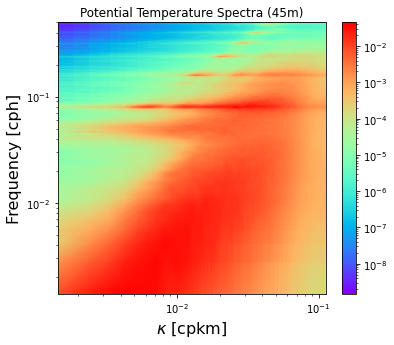

In [231]:
#====================================================
#===================================================
kk = kiso[1:]
omm = om[1:]
#ff = coriolis(38)
#f0 =  0.89e-4
#print(f0)
#kiso = np.logspace(-3,0.,100)

#################
fig = plt.figure(figsize=(6,5))

#fig = plt.figure(figsize=(10,6))
#ax1 = plt.subplot2grid((3,6),(0,1),colspan=2)
#ax2 = plt.subplot2grid((3,6),(1,0),rowspan=2)
#ax3 = plt.subplot2grid((3,6),(1,1),rowspan=2, colspan=2)
ax1 = fig.add_subplot(111)
cs=plt.pcolormesh(kk,omm,60*1*Eiso.T[1:,1:]*kk[None,...]*omm[...,None],
                   shading='gouraud',cmap='rainbow',norm=LogNorm() )
ax1.set_yscale('log')
ax1.set_xscale('log')
plt.title('Potential Temperature Spectra (45m)')
plt.xlabel(r'$\kappa$ [cpkm]',size=16)
plt.ylabel(r'Frequency [cph]',size=16)
#plt.clim([1e-8,1e-6])
plt.colorbar()
#ax1.set_ylim([omm[1], omm[-1]])
#ax1.set_xlim([kk[1],1e-1])
#ax3.set_yticks([])
#plt.title('Mode-1',fontweight='bold',size=20)
#

#plt.savefig(PrntOut+figurename+output_format,format='png',
#            dpi=500,bbox_inches='tight')

plt.show()
